In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from src.tab_parser import *

In [3]:
# mode = int(metadata['mode']) if metadata['mode'] is not None else 1
# beats_in_measure = int(metadata['beats_in_measure'])

# melody, chord = segments_parser(segments, mode, beats_in_measure)

In [4]:
from pathlib import Path

In [5]:
version = 'v7'
data_path = Path('data/midi')
version_path = data_path/version
orig_path = version_path/'midi_sources'

In [6]:
from fastai.data_block import get_files

In [7]:
h_path = orig_path/'hooktheory'

In [8]:
files = get_files(h_path, extensions=['.xml'], recurse=True); files[:10]

[PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/what-a-day/kiefer/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/pre-chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/freedom/chorus.xml')]

In [9]:
# Loading from specific file
# keywords = ['get-lucky', 'daft-punk', 'pre-chorus']
# keywords = ['skrillex', 'scary']
keywords = ['idina', 'verse', 'let']
# keywords = ['game-of-thrones', 'intro', 'ramin']
# keywords = ['kiss-from-a-rose', 'seal']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v7/midi_sources/hooktheory/xml/i/idina-menzel/let-it-go/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/i/idina-menzel/let-it-go/intro-and-verse.xml')]

In [10]:
# import pprint
# file_path = search[0]
# raw_info = proc_xml(file_path)
# pprint.pprint(raw_info)

Skrillex  
G minor -> 9 offset -> C major

minor = 5, G->C=

Daft Punk  
B dorian -> 2 offset -> C major

Let it go  
F minor -> 9 offset -> C major

Game of thrones  
C minor -> 9 offset -> C major

In [11]:
file_path = search[0]
content = load_data(file_path)
root = xml_parser(content)
metadata, version = get_metadata(root)
segments, num_measures = get_lead_sheet(root, version)

In [13]:
import music21

### Create config file

In [14]:
config_opts = dict(sustain=True, sep_octave=True, note_octave=4, chord_octave=3, 
              ts='4/4', ks=0, bpm=120, freq=4, pad_idx=-1, none_idx=0, sus_idx=2, hit_idx=1)

class Config(object):
    def __init__(self, d): self.__dict__ = d
        
config = Config(config_opts)

### Constants

In [15]:
MODE_TO_KEYOFFSET = {
    '1': 0,
    '2': 2,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 11
#     '5': -5,
#     '6': -3,
#     '7': -1
}

In [16]:
PITCH_TO_SD = {
    0: '1',
    1: '1#',
    2: '2',
    3: '2#',
    4: '3',
    5: '4',
    6: '4#',
    7: '5',
    8: '5#',
    9: '6',
    10:'6#',
    11:'7',
}

SD_TO_PITCH = {v:k for k,v in PITCH_TO_SD.items()}

### Classes

In [17]:
from dataclasses import dataclass
import dataclasses
from typing import Dict, Any, AnyStr, List, Sequence, TypeVar, Tuple, Optional, Union

In [18]:
def parse(cls, d):
    cls_keys = cls.__dataclass_fields__.keys()
    kwargs = {key:d[key] for key in cls_keys}
    return cls(**kwargs)

@dataclass
class Base:
    @classmethod
    def from_dict(cls, d):
        cls_keys = cls.__dataclass_fields__.keys()
        kwargs = {key:d[key] for key in cls_keys}
        return cls(**kwargs)
    
    @classmethod
    def parse(cls, d):
        return cls.from_dict(d)

In [19]:
@dataclass
class HMetadata(Base):
    title:str
    BPM:str='120'
    beats_in_measure:str='4'
    key:str='C'
    mode:str='1'

In [20]:
@dataclass
class HNote(Base):
    beat_abs:float
    measure:float
    beat:float
    duration:float
    scale:str
    octave: str
        
    def to_m21(self)->music21.note.Note:
#         if self.scale_degree == 'rest': return None, None
#             n = music21.note.Rest(quarterLength=note_length)
        pitch = self.pitch() + 12*(int(self.octave)+config.note_octave)
        n = music21.note.Note(pitch, quarterLength=self.duration)
#         key.KeySignature(-1)
        return n, float(self.beat_abs)
    
    def pitch(self):
        return SD_TO_PITCH[self.scale]
    
    def end_time(self):
        return self.duration + self.beat_abs
    
    @classmethod
    def parse(cls, d, mode, key_offset):
#         if key_offset > 5: key_offset = key_offset-12
        parsed = roman_to_symbol.hnote_parser(d, mode, key_offset)
        pitch = parsed['pitch']
        scale_degree = PITCH_TO_SD[int((pitch) % 12)]
        octave = (pitch // 12) + 1
        m = {
            'scale': scale_degree,
            'octave': octave,
            'duration': float(d['note_length']),
            'measure': float(d['start_measure']),
            'beat': float(d['start_beat']),
            'beat_abs': float(d['start_beat_abs']),
        }
        return cls.from_dict({**d, **m})

In [72]:
def last_comp(comp):
    if comp is None: return config.none_idx
    return int(comp[-1])

@dataclass
class HChord(Base):
    # ht relative
    scale:int
    base:int
    sus:int
    
    # ht tempo
    duration:float # (AS) TODO: convert to float
    measure:float
    beat:float
    beat_abs:float # (AS) TODO: convert to float
        
    # abs
    symbol:str=None
    quality:str=None
    composition:List[int]
        
    def end_time(self):
        return self.duration + self.beat_abs
        
    def to_m21(self)->music21.chord.Chord:
        notes = [n+config.chord_octave*12 for n in self.composition]
        c = music21.chord.Chord(notes, quarterLength=self.duration)
        return c, float(self.beat_abs)

    @classmethod
    def parse(cls, d, mode, key_offset, reset_to_base=True):
        parsed = roman_to_symbol.hchord_parser(d, mode, key_offset)
        
        # After offset, let's reset the chord to be the lowest possible offset on new scale
        if reset_to_base:
            reset_base = parsed['root'] - parsed['bass']
            parsed = roman_to_symbol.chord_key_shifting(parsed, reset_base)
            # reset chord name
            parsed['symbol'] = roman_to_symbol.chord_to_string(parsed)
        

        
        parsed['composition'] = parsed['composition'].astype(int).tolist()
        
        m = {
            'scale': (int(d['sd']) - (1-int(mode))) % 8,
            'base': last_comp(d['fb']),
            'sus': last_comp(d['sus']),
            'duration': float(d['chord_duration']),
            'measure': float(d['start_measure']),
            'beat': float(d['start_beat']),
            'beat_abs': float(d['start_beat_abs']),
        }
        
        return cls.from_dict({**parsed, **m})

In [73]:
def default_stream(cls=music21.stream.Score, ts='4/4', bpm=120, ks=0):
    # (AS) TODO: use config ts or metadata
    s = cls()
    s.append(music21.instrument.Piano())
    s.append(music21.meter.TimeSignature(ts))
    s.append(music21.tempo.MetronomeMark(number=bpm))
#     s.append(music21.key.KeySignature(ks))
    s.append(music21.key.Key('C'))
    return s

In [74]:
@dataclass
class HPart(Base):
    notes: List[HNote]
    chords: List[HChord]
        
    @classmethod
    def parse(cls, d, metadata):
        mode = metadata['mode']
        key_offset = MODE_TO_KEYOFFSET.get(mode, 0)
        ns = [HNote.parse(n, mode, key_offset) for n in d.get('notes', []) if n['scale_degree'] != 'rest']
        cs = [HChord.parse(c, mode, key_offset) for c in d.get('chords', []) if c['sd'] != 'rest']
        return cls(notes=ns, chords=cs)
    
    
    def duration(self):
        c_last = self.chords[-1].end_time()
        n_last = self.notes[-1].end_time()
        return max(c_last, n_last)
    
    def to_m21(self)->music21.stream.Stream:
        mc = music21.stream.Part()
        mn = music21.stream.Part()
        
        cm21 = [c.to_m21() for c in self.chords]
        for c,d in cm21: mc.insert(d,c)
            
        nm21 = [n.to_m21() for n in self.notes]
        for n,d in nm21: mn.insert(d,n)
        return mn, mc
        
    def min_pitch(self):
        return min([n.pitch for n in self.notes])

In [75]:
@dataclass
class HSong(Base):
    metadata: HMetadata
    parts: List[HPart]
    
    @classmethod
    def parse(cls, metadata, segments):
        m = HMetadata.parse(metadata)
        ps = [HPart.parse(s, metadata) for s in segments]
        return cls(metadata=m, parts=ps)
    
    def duration(self):
        return sum(p.duration() for p in self.parts)
    
    def to_stream(self):
        s = default_stream()
        pc = music21.stream.Part()
        pn = music21.stream.Part()
        
        for p in self.parts:
            mn, mc = p.to_m21()
            pn.append(mn)
            pc.append(mc)
            
        s.insert(0, pn)
        s.insert(0, pc)

#         s.flat.makeNotation(inPlace=True)
        s = s.transpose(0) # hack to get accidentals right. Above method does not work
        # music21 stream
        return s

In [76]:
from src import roman_to_symbol
from src import to_pianoroll
from collections import defaultdict
from midi_data import keyc_offset

In [77]:
import numpy as np

In [78]:
# translator
class Translator():
    @classmethod
    def to_numpy(cls, s:HSong):
        pass
    @classmethod
    def to_song(cls, arr):
        pass

In [79]:
song = HSong.parse(metadata, segments)

In [80]:
stream = song.to_stream()

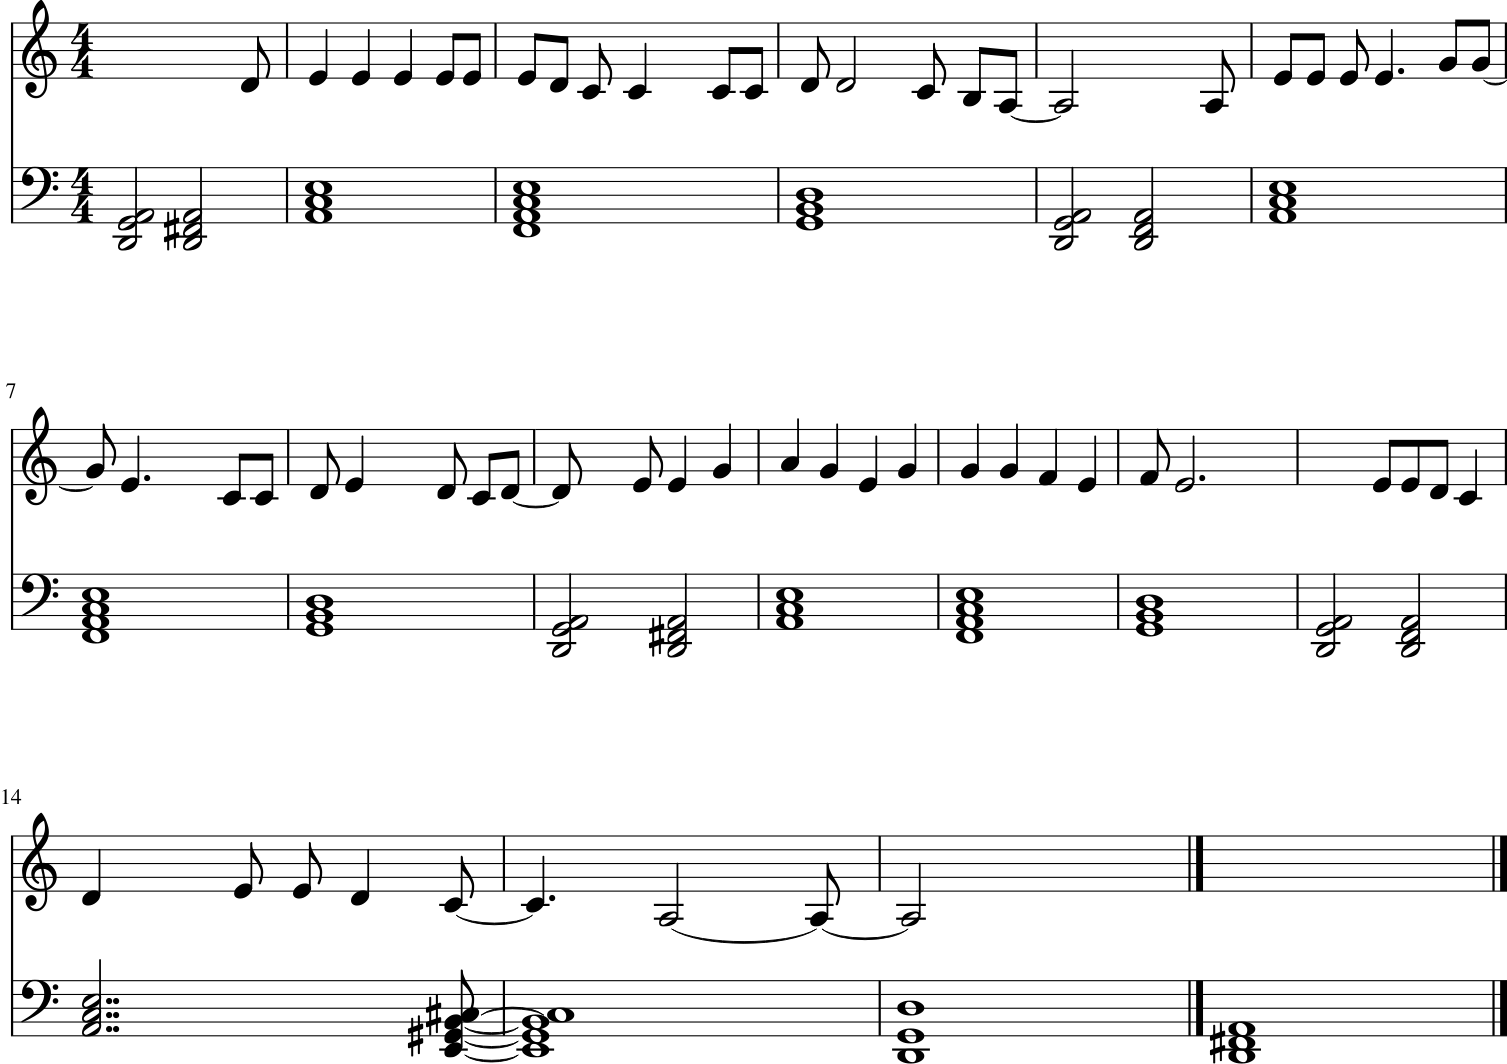

In [81]:
stream.show()

In [82]:
stream.show('midi')

Notes: 
1. need to check normal duration - can we just use sample frequency of 2?
2. need to check if chords are played in the notes section


### Encoding

In [83]:
# song.parts

In [84]:
import numpy as np

In [85]:
max_len = int(song.duration()*config.freq)

In [86]:
# num_comp = (pitch x octave x sustain) x (chord_sd x base x suspend, sustain) x (bar_position x beat_pos)
# timesteps x num_comp
sequence = np.zeros((max_len, 9)); sequence.shape

(272, 9)

In [87]:
part = song.parts[1]

In [88]:
part.duration()

32.0

In [89]:
max_len = int(part.duration()*config.freq)
sequence = np.zeros((max_len, 9))
sequence[:, -2] = np.tile(np.arange(4).repeat(config.freq), int(part.duration())//4)

In [90]:
sequence.shape

(128, 9)

In [91]:
np.arange(4).repeat(config.freq)

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [92]:
def enc_part(part):
    '(pitch x octave x sustain) x (chord_sd x base x suspend, sustain) x (bar_position x beat_pos)'
    max_len = int(part.duration()*config.freq)
    sequence = np.full((max_len, 9), fill_value=config.pad_idx)
    
    # beat_pos
    sequence[:, -2] = np.tile(np.arange(4).repeat(config.freq), int(part.duration())//4)
    # bar_pos
    sequence[:, -1] = np.arange(part.duration()//4).repeat(config.freq*4)
    
    
    for n in part.notes:
        start = n.beat_abs * config.freq
        duration = n.duration * config.freq
        assert(start.is_integer() and duration.is_integer())
        sequence[int(start),0:3] = n.pitch(), n.octave, duration
        
    for c in part.chords:
        start = c.beat_abs * config.freq
        duration = c.duration * config.freq
        assert(start.is_integer() and duration.is_integer())
        sequence[int(start),3:7] = c.scale, c.base, c.sus, duration
    return sequence

In [93]:
eps = [enc_part(p) for p in song.parts]

In [94]:
full_song = np.concatenate(eps)

In [109]:
ep = enc_part(part); ep

array([[ 4,  1,  4,  6, ...,  0, 16,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       ...,
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7]])

In [110]:
    scale:int
    base:int
    sus:int
    
    # ht tempo
    duration:float # (AS) TODO: convert to float
    measure:float
    beat:float
    beat_abs:float # (AS) TODO: convert to float
        
    # abs
    symbol:str
    quality:str
    composition:List[int]

In [111]:
def dec_note(ts, beat_abs):
    p,o,dur = ts[:3]
    
    beat, measure = ts[-2:] if ts.shape[0] == 9 else None, None
    note = HNote(octave=o, duration=dur/config.freq, scale=PITCH_TO_SD[p],
                 beat_abs=beat_abs/config.freq, beat=beat, measure=measure)
    return note

def dec_chord(ts, beat_abs):
    sd,base,sus,dur = ts[3:7]
    
    beat, measure = ts[-2:] if ts.shape[0] == 9 else None, None
    
    chord = HChord(scale=sd, base=base, sus=sus, duration=dur/config.freq,
                 beat_abs=beat_abs/config.freq, beat=beat, measure=measure)
    return chord

def dec_part(part):
    '(pitch x octave x sustain) x (chord_sd x base x suspend, sustain) x (bar_position x beat_pos)'
    notes = [dec_note(ts,idx) for idx,ts in enumerate(part) if ts[0] != -1]
    chords = [dec_chord(ts,idx) for idx,ts in enumerate(part) if ts[3] != -1]
    
    return HPart(notes=notes, chords=chords)

In [112]:
part.chords[0]

HChord(scale=6, base=0, sus=0, duration=4.0, measure=1.0, beat=1.0, beat_abs=0.0, symbol='am', quality='m', composition=[9, 12, 16])

In [113]:
ep[0]

array([ 4,  1,  4,  6,  0,  0, 16,  0,  0])

In [152]:
sd,fb,sus,dur = ep[0][3:7]
fb = None if fb == 0 else fb
sus = None if sus == 0 else sus

In [153]:
d = {
    'sd': sd,
    'fb': fb,
    'sus': sus,
    'sec': None,
    'borrowed': None,
    'chord_duration': dur,
    'start_measure': 2,
    'start_beat': 4,
    'start_beat_abs': 3
    
}
HChord.parse(d, mode='1', key_offset=0, reset_to_base=False)

KeyError: 'alternate'

In [154]:
scale = roman_to_symbol.get_scale(0); scale

[0,
 2,
 4,
 5,
 7,
 9,
 11,
 12,
 14,
 16,
 17,
 19,
 21,
 23,
 24,
 26,
 28,
 29,
 31,
 33,
 35,
 36,
 38,
 40,
 41,
 43,
 45,
 47,
 48,
 50,
 52,
 53,
 55,
 57,
 59]

In [163]:
fb=6

In [164]:
scale = roman_to_symbol.get_scale(0)
# set compositional notes
comp, chord_type = roman_to_symbol.set_compositions(scale, fb, sd)

In [165]:
comp, chord_type

(array([11, 14, 17]), 6)

In [168]:
quality

'o'

In [166]:
# determine the quality by triads or seventh
# (9, 11, 13-th chords are seen as seventh)
comp_t = comp[0:3] if chord_type is 5 else comp[0:4]
quality = roman_to_symbol.get_quality(comp_t)

# add shift from secondary chords
# comp = (comp + sec_offset)

# set compvec (for sus/add/omit)
comp_vec = roman_to_symbol.comp_to_compvec(comp)

# sus (omit 3)
comp_vec = roman_to_symbol.set_sus(comp_vec, scale, sd, sus)

# set inversion (won't change the root, but bass)
inv = roman_to_symbol.get_num_inversion(fb)
comp_vec = roman_to_symbol.set_inversion(comp_vec, inv)

# set result
comp = roman_to_symbol.compvec_to_comp(comp_vec)

In [167]:
comp

array([11, 14, 17], dtype=object)

In [158]:
comp_vec

array([11, None, 14, None, 17, None, None, None, None], dtype=object)

In [117]:
%debug

> /home/ubuntu/midi_generator/src/roman_to_symbol.py(122)get_quality()
    120         quality = seventh_symbol[3]
    121     else:
--> 122         raise ValueError("Unknow compostions", comp)
    123 
    124     return quality

ipdb> up
> /home/ubuntu/midi_generator/src/roman_to_symbol.py(534)hchord_parser()
    532     # (9, 11, 13-th chords are seen as seventh)
    533     comp_t = comp[0:3] if chord_type is 5 else comp[0:4]
--> 534     quality = get_quality(comp_t)
    535 
    536     # add shift from secondary chords

ipdb> comp
array([], dtype=float64)
ipdb> quit


In [106]:
def dec_chord(ts, beat_abs):
    sd,base,sus,dur = ts[3:7]
    
    beat, measure = ts[-2:] if ts.shape[0] == 9 else None, None
    
    chord = HChord(scale=sd, base=base, sus=sus, duration=dur/config.freq,
                 beat_abs=beat_abs/config.freq, beat=beat, measure=measure)
    return chord


In [69]:
segments[0]['chords']

[OrderedDict([('sd', '4'),
              ('fb', None),
              ('sec', None),
              ('sus', 'sus4'),
              ('pedal', None),
              ('alternate', None),
              ('borrowed', '-2'),
              ('chord_duration', '2'),
              ('start_measure', '1'),
              ('start_beat', '1'),
              ('start_beat_abs', '0'),
              ('isRest', '0')]),
 OrderedDict([('sd', '4'),
              ('fb', None),
              ('sec', None),
              ('sus', None),
              ('pedal', None),
              ('alternate', None),
              ('borrowed', '-2'),
              ('chord_duration', '2'),
              ('start_measure', '1'),
              ('start_beat', '3'),
              ('start_beat_abs', '2'),
              ('isRest', '0')])]

In [64]:
ep

array([[ 4,  1,  4, -2, ...,  0, 16,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       [-1, -1, -1, -1, ..., -1, -1,  0,  0],
       ...,
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7],
       [-1, -1, -1, -1, ..., -1, -1,  3,  7]])

In [65]:
dec_part(ep)

TypeError: __init__() missing 3 required positional arguments: 'symbol', 'quality', and 'composition'

In [66]:
%debug

> <ipython-input-63-17ea0553c0ca>(14)dec_chord()
     12     beat, measure = ts[-2:] if ts.shape[0] == 9 else None, None
     13     note = HChord(scale=sd, base=base, sus=sus, duration=dur/config.freq,
---> 14                  beat_abs=beat_abs/config.freq, beat=beat, measure=measure)
     15     return note
     16 

ipdb> quit


In [80]:
[(c.scale, c.base, c.sus) for c in c1]

[(1, 0, 4), (1, 0, 0)]

In [81]:
[(n.pitch(), n.octave) for n in n1]

[(2, 1.0)]

In [83]:
# for p in song.parts:
    

In [39]:
# translator
class Translator():
    @classmethod
    def to_numpy(cls, s:HSong):
        pass
    @classmethod
    def to_song(cls, arr):
        pass

In [54]:
max_len

512.0

In [49]:
stream.show('midi')

In [45]:
segments[0]['notes']

[OrderedDict([('start_beat_abs', '0'),
              ('start_measure', '1'),
              ('start_beat', '1'),
              ('note_length', '0.5'),
              ('scale_degree', '2'),
              ('octave', '1'),
              ('isRest', '0')]),
 OrderedDict([('start_beat_abs', '0.5'),
              ('start_measure', '1'),
              ('start_beat', '1.5'),
              ('note_length', '0.5'),
              ('scale_degree', '3'),
              ('octave', '1'),
              ('isRest', '0')]),
 OrderedDict([('start_beat_abs', '1'),
              ('start_measure', '1'),
              ('start_beat', '2'),
              ('note_length', '0.5'),
              ('scale_degree', '5'),
              ('octave', '0'),
              ('isRest', '0')]),
 OrderedDict([('start_beat_abs', '1.5'),
              ('start_measure', '1'),
              ('start_beat', '2.5'),
              ('note_length', '1'),
              ('scale_degree', '2'),
              ('octave', '1'),
              ('isRest'